In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
input_shape = (224, 224, 3)

In [14]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)


In [15]:
for layer in resnet_model.layers:
    layer.trainable = False

for layer in inception_model.layers:
    layer.trainable = False

for layer in efficientnet_model.layers:
    layer.trainable = False


In [16]:
input_tensor = Input(shape=input_shape)
resnet_features = GlobalAveragePooling2D()(resnet_model(input_tensor))
inception_features = GlobalAveragePooling2D()(inception_model(input_tensor))
efficientnet_features = GlobalAveragePooling2D()(efficientnet_model(input_tensor))


In [17]:
x = Concatenate()([resnet_features, inception_features, efficientnet_features])
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x) 

In [18]:
ensemble_model = Model(inputs=input_tensor, outputs=output)

In [19]:
ensemble_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


In [21]:
train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    'data/test',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [22]:
history = ensemble_model.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
54/54 [==============================] - 209s 4s/step - loss: 0.8966 - accuracy: 0.8200 - val_loss: 0.1269 - val_accuracy: 0.9492
Epoch 2/10
54/54 [==============================] - 193s 4s/step - loss: 0.1133 - accuracy: 0.9561 - val_loss: 0.0731 - val_accuracy: 0.9746
Epoch 3/10
54/54 [==============================] - 196s 4s/step - loss: 0.0690 - accuracy: 0.9747 - val_loss: 0.0979 - val_accuracy: 0.9654
Epoch 4/10
54/54 [==============================] - 192s 4s/step - loss: 0.0764 - accuracy: 0.9681 - val_loss: 0.1338 - val_accuracy: 0.9515
Epoch 5/10
54/54 [==============================] - 191s 4s/step - loss: 0.1520 - accuracy: 0.9460 - val_loss: 0.0847 - val_accuracy: 0.9677
Epoch 6/10
54/54 [==============================] - 190s 4s/step - loss: 0.0613 - accuracy: 0.9799 - val_loss: 0.0710 - val_accuracy: 0.9769
Epoch 7/10
54/54 [==============================] - 190s 4s/step - loss: 0.0606 - accuracy: 0.9792 - val_loss: 0.0472 - val_accuracy: 0.9815
Epoch 8/10
54

In [23]:
tf.saved_mode l.save(ensemble_model, 'ensemble_model')

INFO:tensorflow:Assets written to: ensemble_model\assets


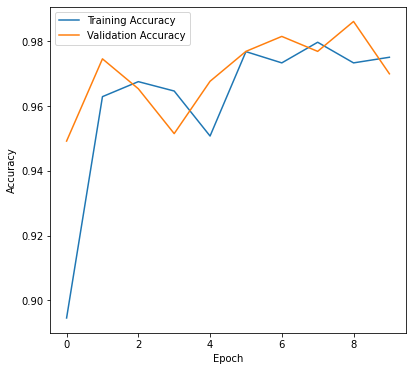

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

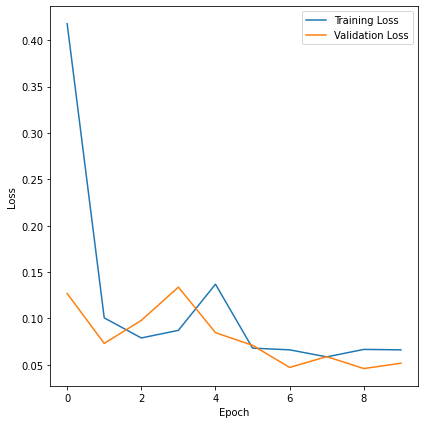

In [25]:
plt.figure(figsize=(6, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 1726 images belonging to 2 classes.


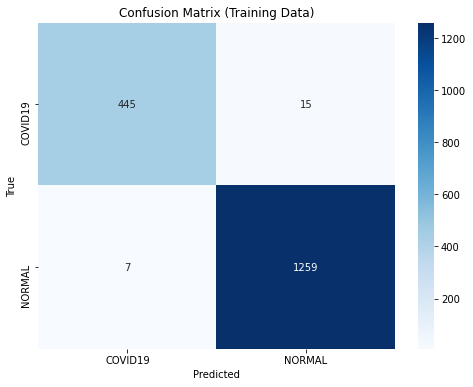

              precision    recall  f1-score   support

     COVID19       0.98      0.97      0.98       460
      NORMAL       0.99      0.99      0.99      1266

    accuracy                           0.99      1726
   macro avg       0.99      0.98      0.98      1726
weighted avg       0.99      0.99      0.99      1726



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
num_classes = 2 

loaded_model = tf.saved_model.load('ensemble_model')

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)


y_true = []
y_pred = []

for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    y_true.extend(np.argmax(batch_labels, axis=1))
    
   
    batch_predictions = loaded_model(batch_images)
    y_pred.extend(np.argmax(batch_predictions, axis=1))

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=['COVID19', 'NORMAL'],
            yticklabels=['COVID19', 'NORMAL'])
            
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Data)')
plt.show()

print(classification_report(y_true, y_pred, target_names=['COVID19', 'NORMAL']))


In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

loaded_model = tf.saved_model.load('ensemble_model')

image_path = '2.jpg'  

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array = preprocess_input(img_array) 

predictions = loaded_model(img_array, training=False)  

class_labels = ['COVID19', 'NORMAL'] 
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

print("Predicted Class Label:", predicted_class_label)
print("Class Probabilities:", predictions)


Predicted Class Label: COVID19
Class Probabilities: tf.Tensor([[1.0000000e+00 2.3473923e-09]], shape=(1, 2), dtype=float32)
